In [1]:
using Plots

### Q1

In [2]:
abstract type AbstractWalker end

In [3]:
abstract type Abstract2DWalker <: AbstractWalker end

In [4]:
struct Location
    x::Int
    y::Int
end 

In [5]:
mutable struct Walker2D <: Abstract2DWalker
   position::Location 
end

In [6]:
methods(Walker2D)

# 2 methods for type constructor:
[1] Walker2D(position::Location) in Main at In[5]:2
[2] Walker2D(position) in Main at In[5]:2

In [67]:
Walker = Walker2D(Location(0,0))

Walker2D(Location(0, 0))

In [7]:
Walker2D(x::Int, y::Int) = Walker2D(Location(x,y))

Walker2D

In [8]:
function make_tuple(loc::Location)
    return (loc.x, loc.y)
end

make_tuple (generic function with 1 method)

In [9]:
function pos(walker::Abstract2DWalker)
   return walker.position 
end

function set_pos!(walker::Abstract2DWalker, l::Location)
   walker.position = l
end

function jump(walker::Abstract2DWalker)
    neighbour = rand([(1,0), (0,1), (-1,0), (0,-1)])
    coords = make_tuple(pos(walker))
    return Location(coords .+ neighbour...)
end

function jump!(walker::Abstract2DWalker, jump)
    set_pos!(walker, jump(walker))
end


function trajectory(walker::Abstract2DWalker, N::Int, jump)
    traj = [(0,0)]
    for i in 1:N
        jump!(walker, jump)
        push!(traj, make_tuple(pos(walker)))
    end
    return traj 
end

trajectory (generic function with 1 method)

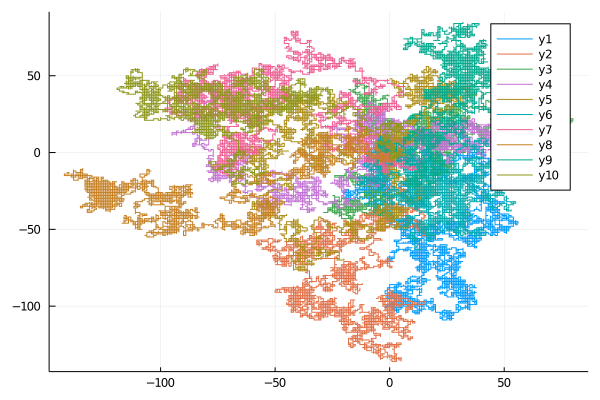

In [106]:
Walker = Walker2D(0,0)
p = plot(trajectory(Walker, 10000))
for i in 1:9
    local_walker = Walker2D(0,0)
    plot!(p, trajectory(local_walker, 10000), jump)
end
p

### Q2

In [10]:
@enum InfectionStatus S I R

mutable struct Agent <: Abstract2DWalker
   position::Location
   state::InfectionStatus
end

In [11]:
function agent_jump(agent::Agent, boundary::Int)
    neighbour = rand([(1,0), (0,1), (-1,0), (0,-1)])
    coords = make_tuple(pos(agent))
    new_pos = coords .+ neighbour
    if any(abs.(new_pos) .> boundary)
        return pos(agent)
    else
        return Location(new_pos...)
    end
end

function jump!(walker::Abstract2DWalker, boundary::Int, jump)
    set_pos!(walker, jump(walker, boundary))
end

function trajectory(walker::Abstract2DWalker, N::Int, boundary::Int, jump)
    traj = [(0,0)]
    for i in 1:N
        jump!(walker, boundary, jump)
        push!(traj, make_tuple(pos(walker)))
    end
    return traj 
end

trajectory (generic function with 2 methods)

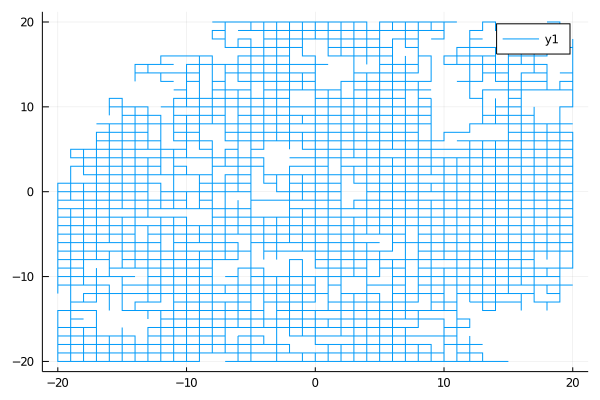

In [154]:
agent = Agent(Location(0,0), S);
plot(trajectory(agent, 10000, 20, agent_jump))

### Q3

In [12]:
function initialise(L::Int, N::Int)
    default_location = Location(0,0)
    agents = [Agent(default_location, I)]
    all_locations = [(i,j) for i in -L:L for j in -L:L if (i!=0) & (j!=0)]
    
    for i in 1:N-1
       new_location = rand(all_locations)
       push!(agents, Agent(Location(new_location...), S))
       filter!(x->x!=new_location,all_locations)
    end
    
    return agents 
end


initialise (generic function with 1 method)

In [13]:
init_agents = initialise(10, 20)

20-element Array{Agent,1}:
 Agent(Location(0, 0), I)
 Agent(Location(9, -9), S)
 Agent(Location(1, 9), S)
 Agent(Location(-7, -4), S)
 Agent(Location(-6, -4), S)
 Agent(Location(-5, -10), S)
 Agent(Location(4, 5), S)
 Agent(Location(7, -6), S)
 Agent(Location(9, 8), S)
 Agent(Location(-6, 10), S)
 Agent(Location(-9, 8), S)
 Agent(Location(8, 6), S)
 Agent(Location(4, 3), S)
 Agent(Location(5, 9), S)
 Agent(Location(-10, 4), S)
 Agent(Location(2, -5), S)
 Agent(Location(8, 1), S)
 Agent(Location(8, 5), S)
 Agent(Location(9, -6), S)
 Agent(Location(6, -6), S)

In [14]:
function colour_mapping(inf::InfectionStatus)
   if inf == S
        return :yellow
    elseif inf == I
        return :red
    else
        return :blue
    end
end

function visualise_agents(agents)
    all_locations = [make_tuple(pos(agent)) for agent in agents]
    all_colours = [colour_mapping(agent.state) for agent in agents]
    scatter(all_locations, c=all_colours, ratio = 1)
end

visualise_agents (generic function with 1 method)

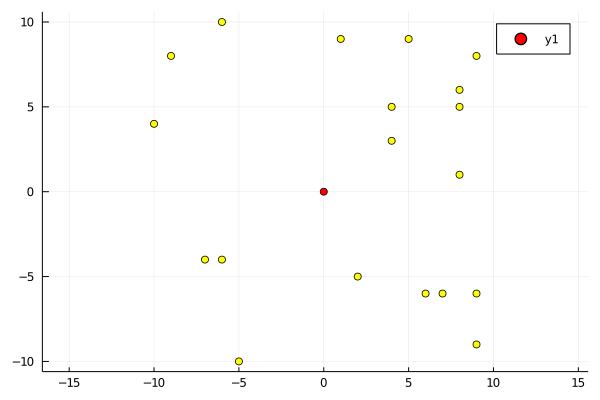

In [15]:
visualise_agents(init_agents)

### Q4

In [129]:
function step!(agents, L, p_I, p_R)
    agent = rand(agents)
    all_locations = [(i,j) for i in -L:L for j in -L:L]
    all_occupied_locations = [make_tuple(pos(x)) for x in agents]
    
    new_pos = rand(all_locations)
    index = findfirst(all_occupied_locations .== [new_pos])
    if typeof(index) != Nothing
        victim = agents[index]
        if agent.state == I
           if (victim.state == S)&(rand() < p_I)
               victim.state = I   
           end
           if rand() < p_R 
               agent.state = R     
           end 
        end
    else
        set_pos!(agent, Location(new_pos...))
    end
    
end

step! (generic function with 1 method)

In [175]:
function sweep!(agents, L, p_I, p_R) 
   sim = [step!(agents, L, p_I, p_R) for i in 1:length(agents)]
end

function dynamics!(agents, L, p_I, p_R, n_sweeps)
   system_states = []
   for i in 1:n_sweeps
       sweep!(agents, L, p_I, p_R) 
        snapshot = Dict(
            "state"=>deepcopy(agents),
            "n_sus"=>sum([1 for i in agents if i.state == S]),
            "n_inf"=>sum([1 for i in agents if i.state == I]),
            "n_rec"=>sum([1 for i in agents if i.state == R]),
        )
        push!(system_states, snapshot)
    end
    return system_states
end

dynamics! (generic function with 2 methods)

In [189]:
sweeps = 1000
init_agents = initialise(20, 100);
all_states = dynamics!(init_agents, 10, 0.8, 0.05, sweeps);
ns = [x["n_sus"] for x in all_states];
ni = [x["n_inf"] for x in all_states];
nr = [x["n_rec"] for x in all_states];

for i in 1:49
    init_agents = initialise(20, 100);
    all_states = dynamics!(init_agents, 10, 0.8, 0.05, sweeps);
    n_s = [x["n_sus"] for x in all_states];
    n_i = [x["n_inf"] for x in all_states];
    n_r = [x["n_rec"] for x in all_states];
    
    ns = (ns .+ n_s)
    ni = (ni .+ n_i)
    nr = (nr .+ n_r)
end

ns = ns ./ 50;
ni = ni ./ 50;
nr = nr ./ 50;

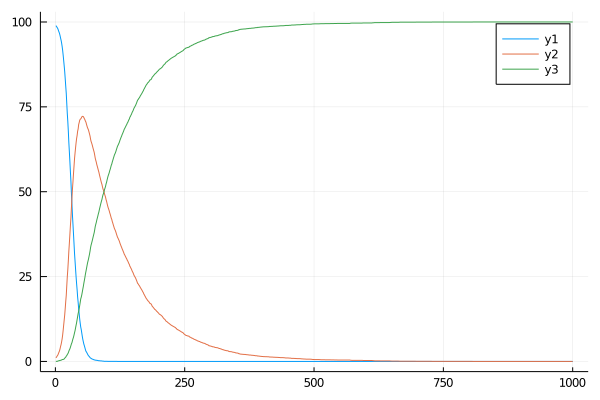

In [190]:
# i got distracted in the previous exercise on thinking about how to compute the mean without saving every simulation in memory
# so now I pay the price in being unable to provide error bars
# that's probably why they're not always shown 
plot(ns)
plot!(ni)
plot!(nr)